### DCS 630
# Week 8
## Assignment 8

 

### Name: Aniruddha Joshi
### Date: May 04, 2024

In [162]:
#Defining Libraries required for import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import sklearn as sk
import textblob as tb
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
import operator
import unicodedata
import sys
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import geopandas as gpd
from geopy.geocoders import Nominatim
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_squared_error, r2_score, classification_report
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import warnings
import plotly.express as px
import plotly.io as pio

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict


In [163]:
# Initial settings
pio.renderers.default = "notebook"
warnings.filterwarnings("ignore", category=UserWarning)

##### Questions:
-Plot the data with proper labeling and make some observations on the graph.

-Split this data into a training and test set. Use the last year of data (July 2020 – June 2021) 
of data as your test set and the rest as your training set.

-Use the training set to build a predictive model for the monthly retail sales.

-Use the model to predict the monthly retail sales on the last year of data.

-Report the RMSE of the model predictions on the test set.

In [164]:
#Load the dataset as a Pandas data frame.

us_retail_sales_df = pd.read_csv('us_retail_sales.csv')       

In [165]:

# Set the index column and parse dates
us_retail_sales_df = us_retail_sales_df.set_index('YEAR')
#us_retail_sales_df.index = pd.to_datetime(us_retail_sales_df.index, format='%Y')

print(us_retail_sales_df)

         JAN     FEB     MAR     APR     MAY     JUN       JUL       AUG  \
YEAR                                                                       
1992  146925  147223  146805  148032  149010  149800  150761.0  151067.0   
1993  157555  156266  154752  158979  160605  160127  162816.0  162506.0   
1994  167518  169649  172766  173106  172329  174241  174781.0  177295.0   
1995  182413  179488  181013  181686  183536  186081  185431.0  186806.0   
1996  189135  192266  194029  194744  196205  196136  196187.0  196218.0   
1997  202371  204286  204990  203399  201699  204675  207014.0  207635.0   
1998  209666  209552  210832  213633  214639  216337  214841.0  213636.0   
1999  223997  226250  227417  229037  231235  231903  233948.0  236566.0   
2000  243436  247133  249825  245831  246201  248160  247176.0  247576.0   
2001  252654  252704  250328  254763  255218  254022  252997.0  254560.0   
2002  256307  257670  257059  261333  257573  259786  262769.0  265043.0   
2003  267230

#### Convert the data to time series dataframe

In [166]:
# Melt the DataFrame
df_melted = us_retail_sales_df.melt(ignore_index=False, var_name='month', value_name='data')

#copy the year in temp column
df_melted['temp'] = df_melted.index # df_melted['month'] # df_melted.index.to_period('M').astype(str) 
#remove indexing
df_melted= df_melted.reset_index(drop=True)
#Concatinate the year and month dataframe
df_melted['year-month'] = pd.to_datetime(df_melted['temp'].astype(str) + '-' +  df_melted['month'])

#sort based on year-month
df_melted=df_melted.sort_values(by='year-month')

#drop unwated temp/column
df_melted=df_melted.drop(columns=['temp','month'])

#remove last empty readings
df_melted = df_melted.dropna()

#Check the data
df_melted.head(5)


,data,year-month
0,146925.0,1992-01-01
30,147223.0,1992-02-01
60,146805.0,1992-03-01
90,148032.0,1992-04-01
120,149010.0,1992-05-01


Text(0.5, 1.0, 'Year-Month Vs Prices')

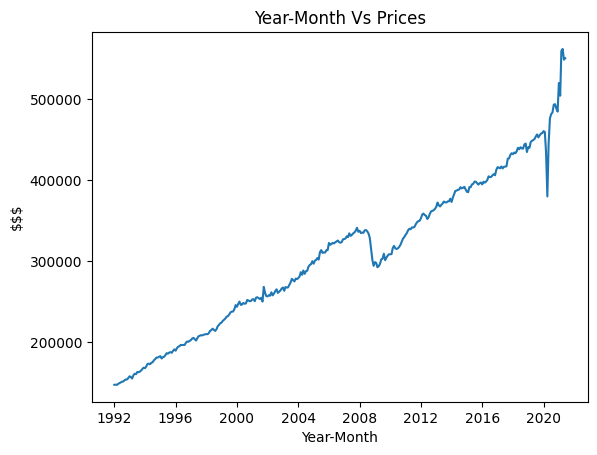

In [167]:
#Plot the data
plt.plot(df_melted['year-month'],df_melted['data'])
# Labels
plt.xlabel('Year-Month')
plt.ylabel('$$$') 
plt.title('Year-Month Vs Prices') 

#### Comments
The graph shows the relationship between Month-year Vs Retail prices.

There increase is prices looks linear however data shows significant dips in 2008 and in 2020/2021. Those dips seem to be related to economic downturn during housing market crash and Covid pandemic.


In [168]:
#print the shape of the data
df_melted.shape

(354, 2)

#### Split this data into a training and test set. Use the last year of data (July 2020 – June 2021) 


In [169]:
# Split the training and testing data
length= df_melted.shape[0]
#Get all records except the last 12 records for training data
training_data_df=df_melted[:length-12]

#For test data, get the last 12 rcods
 
test_data_df =df_melted[length-12:]

#check the test data from July 2020 – June 2021
test_data_df

,data,year-month
208,481627.0,2020-07-01
238,483716.0,2020-08-01
268,493327.0,2020-09-01
298,493991.0,2020-10-01
328,488652.0,2020-11-01
358,484782.0,2020-12-01
29,520162.0,2021-01-01
59,504458.0,2021-02-01
89,559871.0,2021-03-01
119,562269.0,2021-04-01


In [170]:
#reset index. Remove indexing to simply graphs 
training_data_df=training_data_df.reset_index(drop=True)
training_data_df

,data,year-month
0,146925.0,1992-01-01
1,147223.0,1992-02-01
2,146805.0,1992-03-01
3,148032.0,1992-04-01
4,149010.0,1992-05-01
...,...,...
337,459610.0,2020-02-01
338,434281.0,2020-03-01
339,379892.0,2020-04-01
340,444631.0,2020-05-01


#### Use the training set to build a predictive model for the monthly retail sales.

In [171]:
model = ARIMA(training_data_df['data'], order=(25,3,2))  # 
model_fit = model.fit()  

#p= 25 values form the past samples
#d=3 The model will perform differencing once to remove any trend in the data before making predictions.
#q=2 The model will use a moving average of one past forecast error to adjust its current prediction.

#### Use the model to predict the monthly retail sales on the last year of data.

In [172]:
forecast = model_fit.forecast(steps=12)  # Predict the next 12 months 
print(forecast)

342    494390.324842
343    498867.052808
344    499269.687155
345    495309.450565
346    493222.256002
347    492469.333657
348    490889.369419
349    491947.288901
350    493657.088468
351    498557.218956
352    502469.223689
353    504055.217288
Name: predicted_mean, dtype: float64


#### Report the RMSE of the model predictions on the test set.

In [173]:
# 2. Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data_df['data'], forecast))
print("RMSE:", rmse)

RMSE: 34537.01721395114


In [174]:
test_data_df['data']

208    481627.0
238    483716.0
268    493327.0
298    493991.0
328    488652.0
358    484782.0
29     520162.0
59     504458.0
89     559871.0
119    562269.0
149    548987.0
179    550782.0
Name: data, dtype: float64

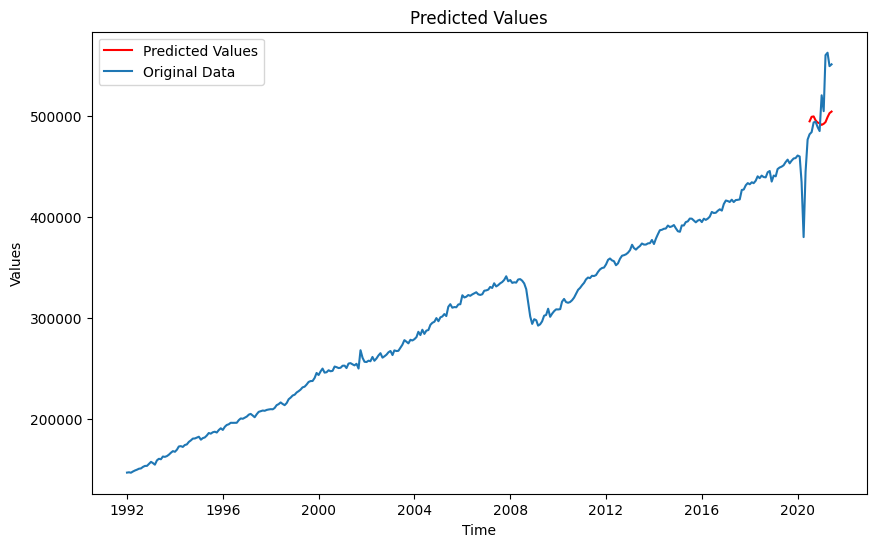

In [175]:
#plot the graph
plt.figure(figsize=(10, 6))
plt.plot(test_data_df['year-month'],forecast, color='red', label='Predicted Values')

# Optional: Add the original data for comparison
plt.plot(df_melted['year-month'],df_melted['data'], label='Original Data')

plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Predicted Values')
plt.legend()
plt.show()

#### Second attempt with different tuning parameters

In [176]:
model = ARIMA(training_data_df['data'], order=(25,5,5))  # 
model_fit = model.fit()  
forecast = model_fit.forecast(steps=12)  # Predict the next 12 months 
print(forecast)
#p= 25 values form the past samples
#d=3 The model will perform differencing once to remove any trend in the data before making predictions.
#q=2 The model will use a moving average of one past forecast error to adjust its current prediction.

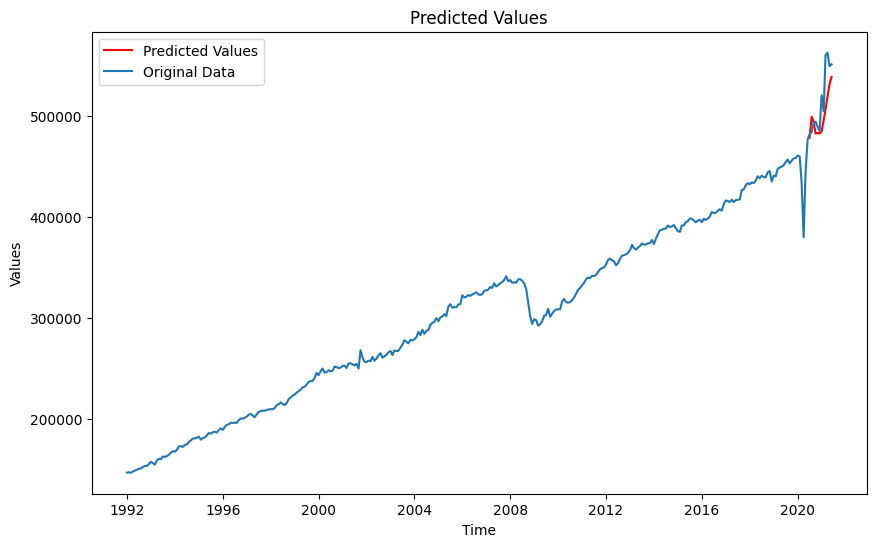

In [ ]:
#plot the graph
plt.figure(figsize=(10, 6))
plt.plot(test_data_df['year-month'],forecast, color='red', label='Predicted Values')

# Optional: Add the original data for comparison
plt.plot(df_melted['year-month'],df_melted['data'], label='Original Data')

plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Predicted Values')
plt.legend()
plt.show()

In [ ]:
# 2. Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data_df['data'], forecast))
print("RMSE:", rmse)

RMSE: 24149.05256437495


##### Conslusion:

By using time series libraries like ARIMA, we can predict the value for the extended periods based on past performance.

However, the model needs to be tuned appropriately. In this experiment, we used ARIMA model to predict the future timeseries values.


